# 1 Configuración del ambiente

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from IPython.display import display
from typing import List, Tuple, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from pandas.api.types import is_period_dtype
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

# 2 Carga de datos limpios

In [129]:
# Cargar los datos del dataset procesados de 01_carga_limpieza
df = pd.read_parquet(r'C:\Users\xavie\Documents\PROYECTOS\fraud-detection-ml\data\processed\01_df_limpieza.parquet')
print("Dataset cargado correctamente")
print(f"Forma del dataset: {df.shape}")

Dataset cargado correctamente
Forma del dataset: (1463837, 39)


In [130]:
df_analsis_historico = df.copy()
df_trx_emisorf = df_analsis_historico[df_analsis_historico['Fraude']== 1].copy()
df_fraude = df[df['Fraude'] == 1].copy()


##  Descripción General del Análisis Temporal de Fraude
Se realizó un análisis exploratorio de los eventos de fraude, utilizando técnicas analíticas y visualizaciones para identificar patrones y tendencias a lo largo del tiempo. Se empleó agregación temporal (mes, trimestre, año, hora del día, días de la semana) para detectar picos, regularidades y posibles amenazas emergentes.

### Métricas Principales Analizadas

Volumen de Transacciones Fraudulentas por Mes

- Mide la frecuencia mensual de fraudes detectados.
- Permite identificar meses con aumentos anómalos que requieren investigación y posibles refuerzos en controles preventivos.

Monto Total de Fraude por Mes

- Analiza el impacto económico mensual del fraude.
- Es crucial para evaluar pérdidas y priorizar acciones de mitigación en meses críticos.

Tendencia Escalada por Hora y Día

- Permite visualizar las horas y días con mayores incidencias, diferenciando tendencias por año.
- Informa sobre ventanas de mayor vulnerabilidad operacional y ayuda a definir horarios de mayor vigilancia.

Mapas de Calor Temporales (Heatmaps)

- Muestran la distribución de fraudes segmentados por horas, días, mes-año y trimestres.
- Importancia: Revelan patrones estacionales, días pico o turnos críticos, facilitando acciones focalizadas y campañas de concienciación.



## Días y horas de mayor riesgo detectados:

- El día de mayor riesgo es viernes, con picos muy marcados en todas las visualizaciones y un crecimiento relevante en 2025.
- Las horas más críticas se ubican entre las 13:00 y 18:00, especialmente en los meses y trimestres recientes, donde el volumen de casos es notoriamente superior en los heatmaps.
- El análisis muestra que este patrón de riesgo se mantiene estable los últimos meses y trimestres, sin variaciones abruptas: los viernes y las tardes siguen concentrando la mayor cantidad de fraudes.


## Evolución histórica (año, mes, trimestre)

In [131]:
# Elegir años a analizar
anos_a_analizar = [2023,2024,2025]  
df_filtrado = filtrar_por_anos(df_fraude, 'year', anos_a_analizar)

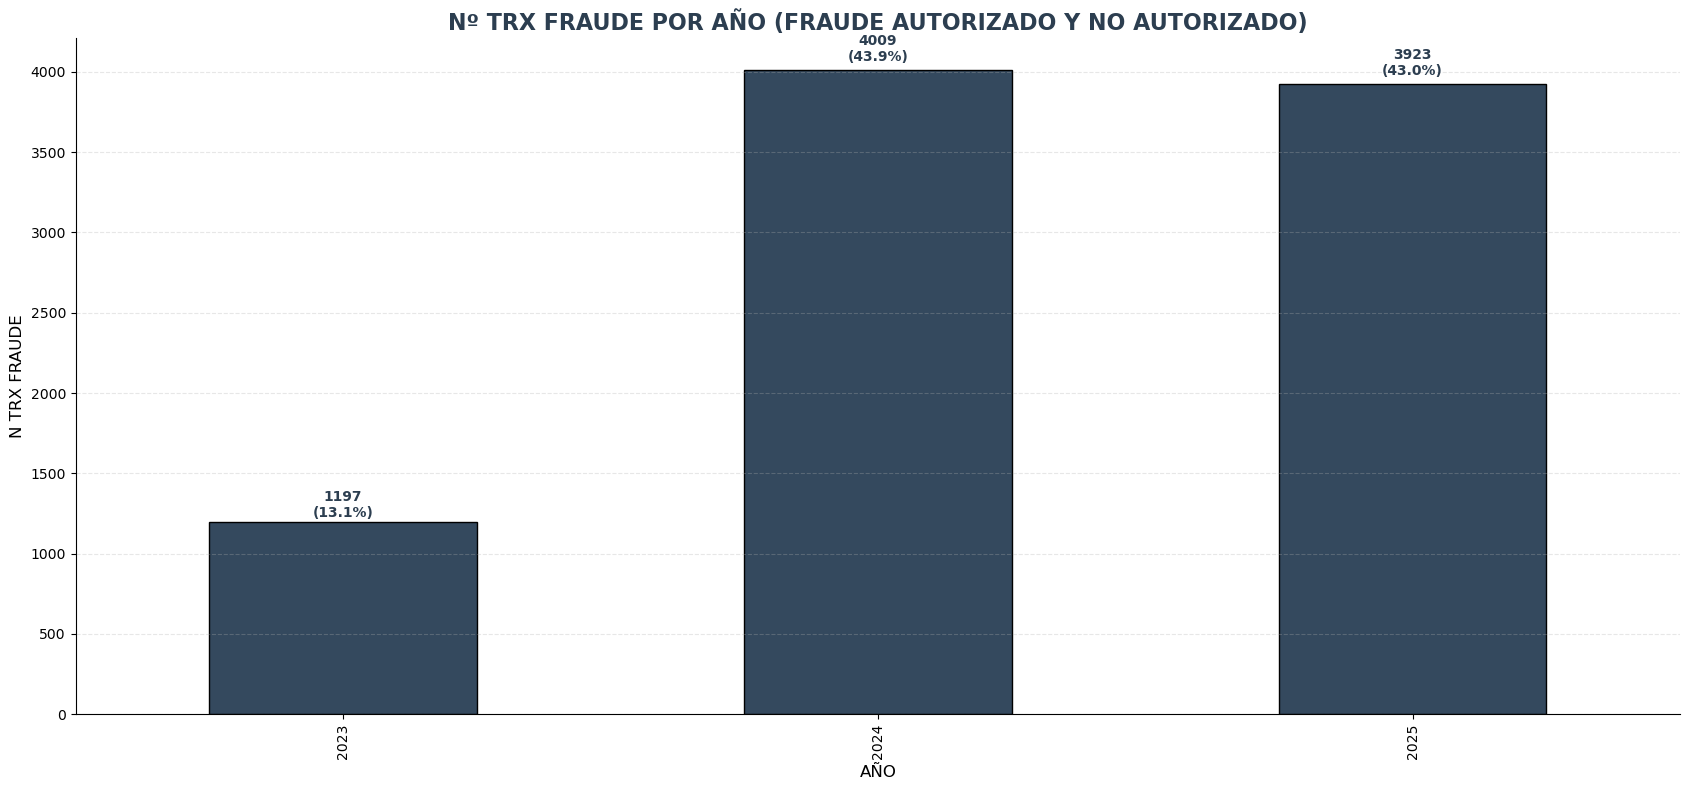

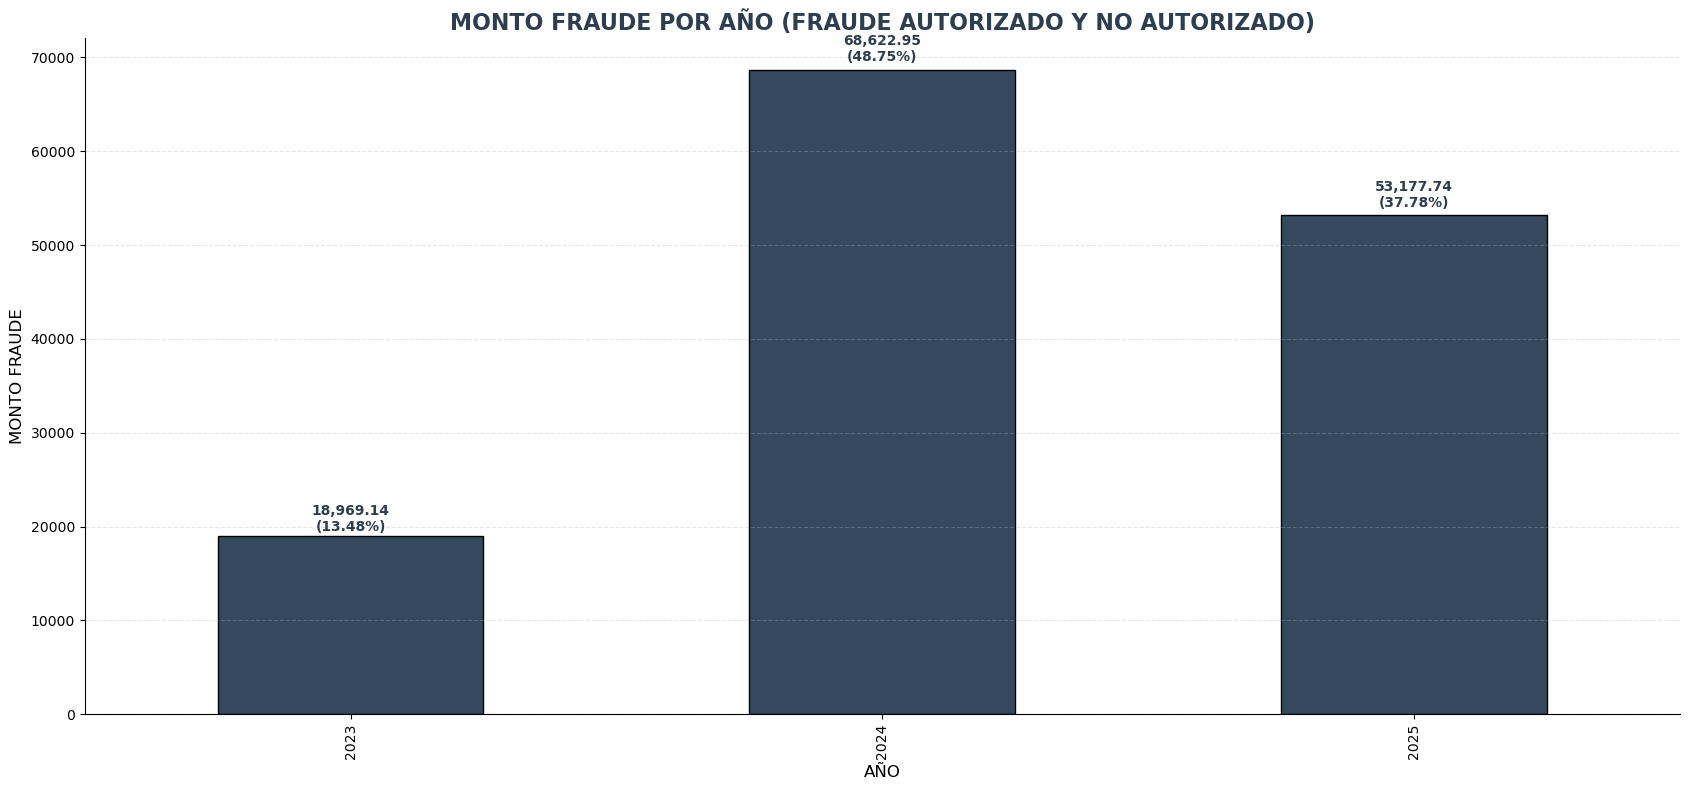

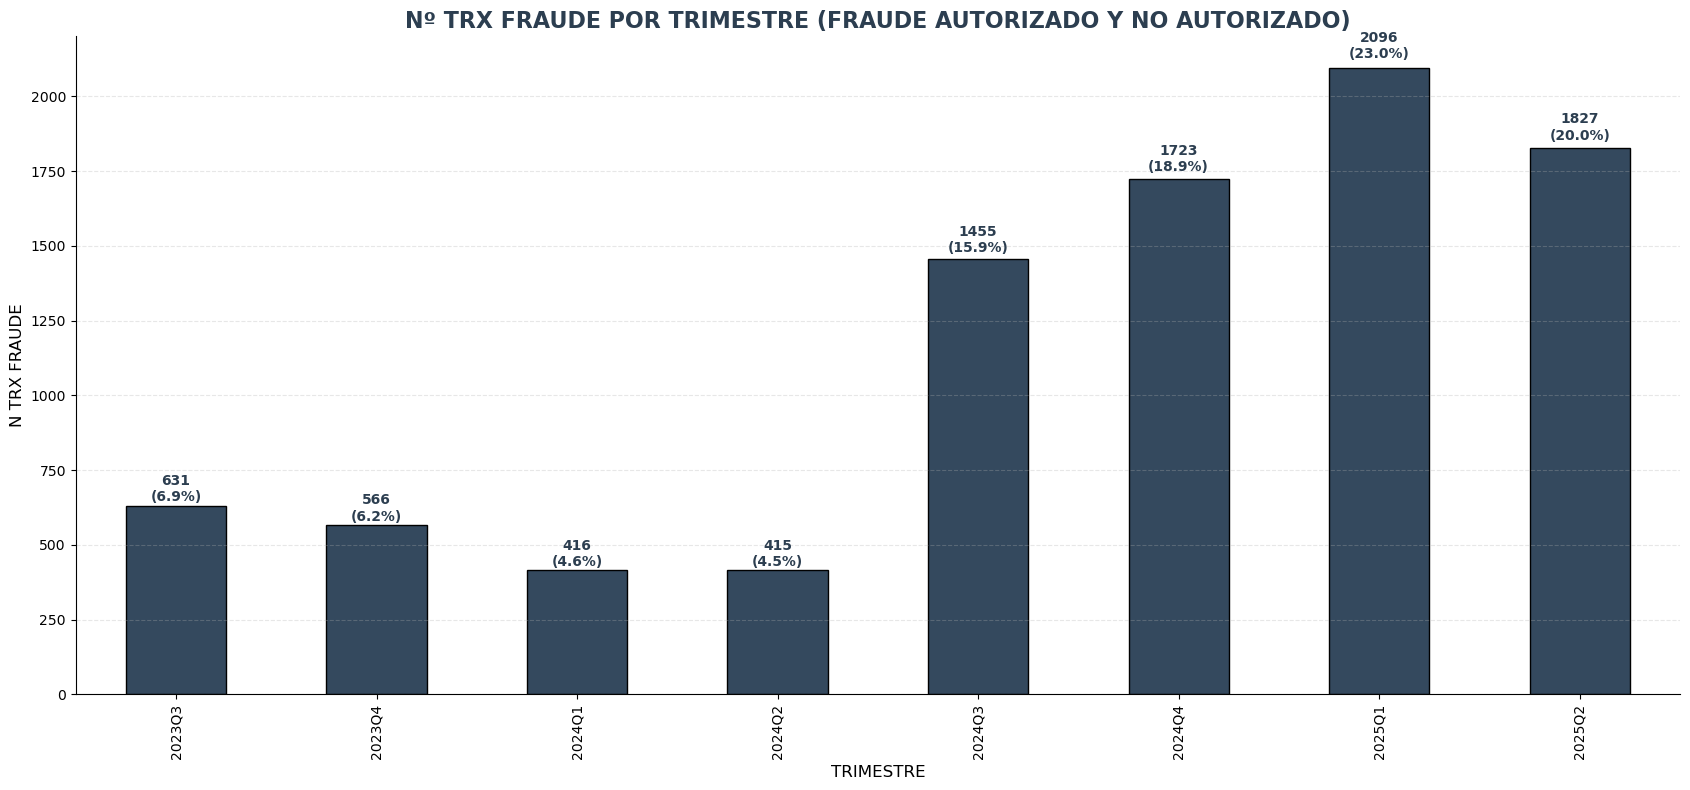

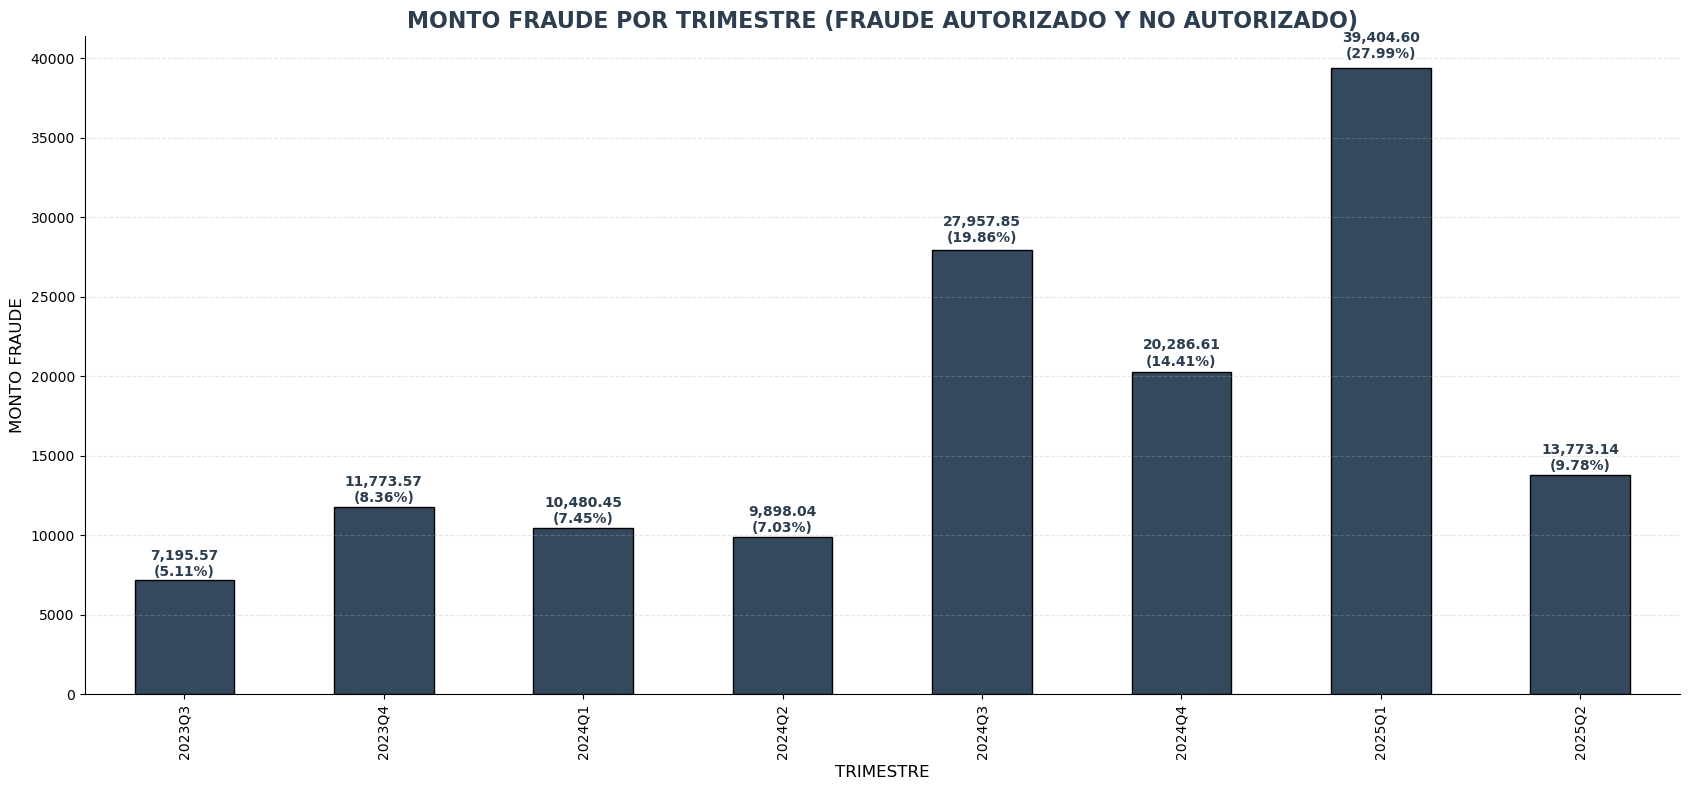

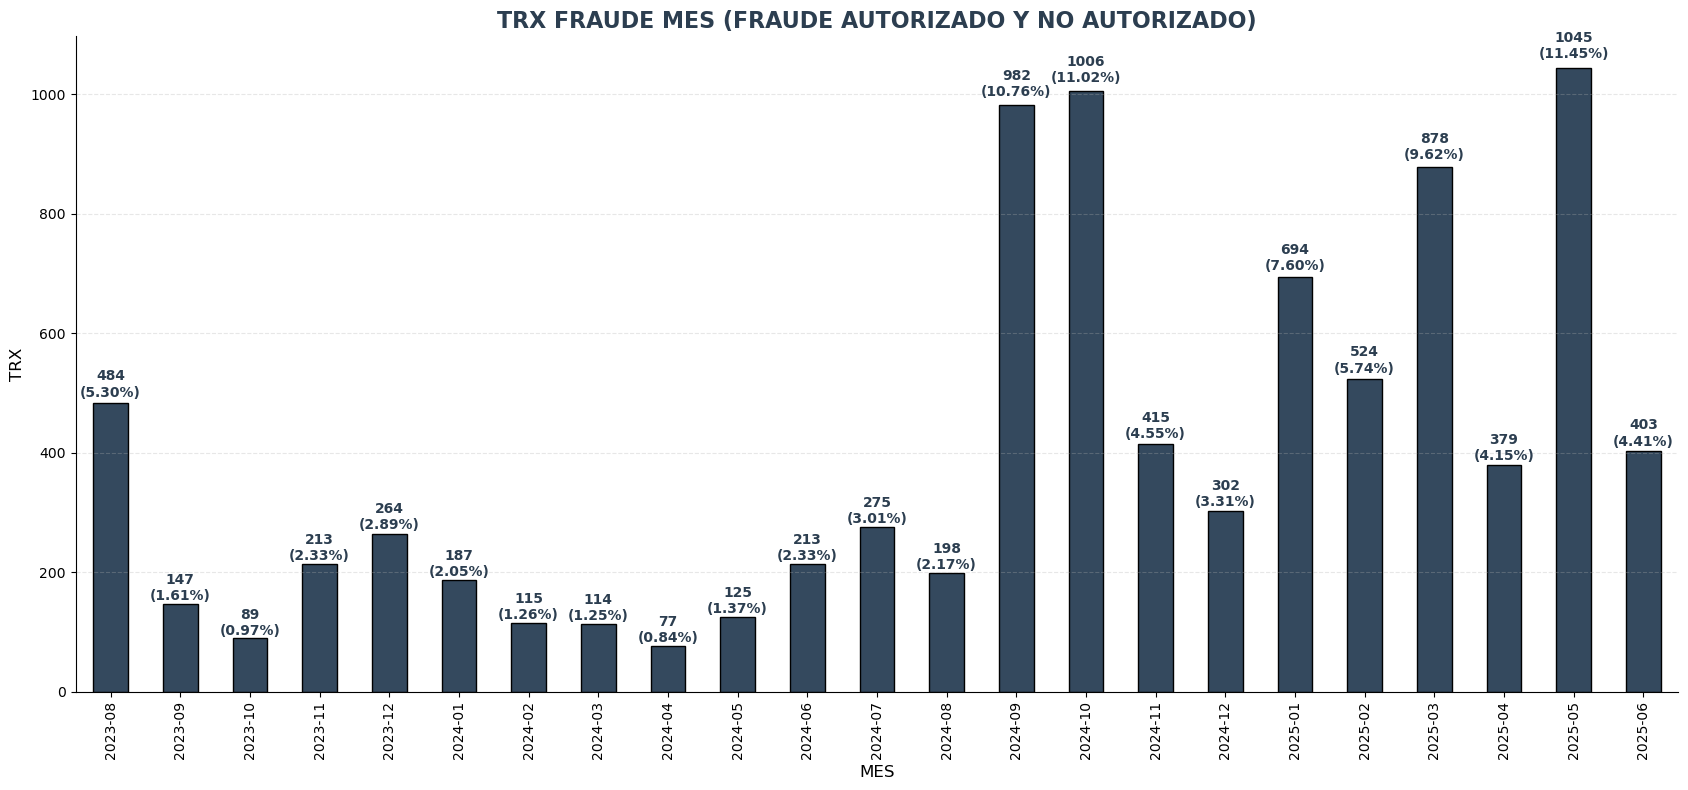

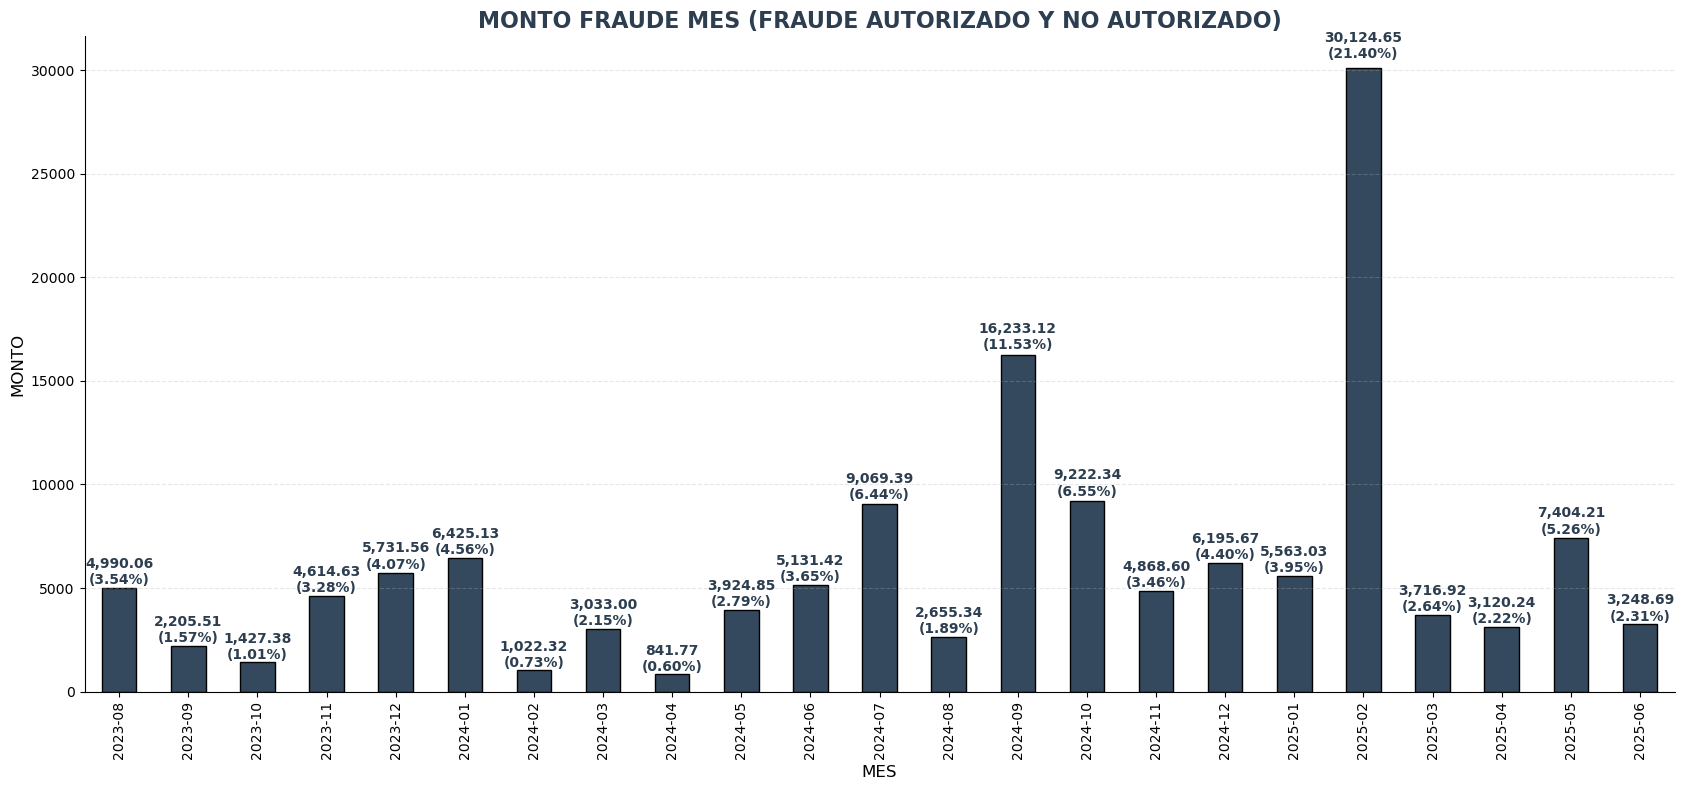

In [132]:
# aplicar filtro ----------
def filtrar_por_anos(df, year_field, years):

    if isinstance(years, list):
        return df[df[year_field].isin(years)]
    return df[df[year_field] == years]

# archivo: plotting.py
def plot_fraud_evolution(df, group_field, value_field, agg_func, title, xlabel, ylabel,
                        value_fmt='int', percent_decimals=1, figsize=(17,8), color='#34495e'):
    agrupado = getattr(df.groupby(group_field)[value_field], agg_func)()
    total = agrupado.sum()
    porcentaje = ((agrupado / total) * 100).round(percent_decimals)

    plt.figure(figsize=figsize)
    ax = agrupado.plot(kind='bar', color=color, edgecolor='black')
    plt.title(title, fontsize=16, fontweight='bold', color='#2c3e50')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Etiquetado profesional de valores y % en cada barra
    for i, (valor, pct) in enumerate(zip(agrupado.values, porcentaje.values)):
        label = int(valor) if value_fmt == 'int' else f"{valor:,.2f}"
        ax.text(i, valor + abs(valor) * 0.01, f"{label}\n({pct:.{percent_decimals}f}%)",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='#2c3e50')
    # Quitar bordes superiores y derechos
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    plt.show()

# generar grafico


# Gráficos anuales
plot_fraud_evolution(df_filtrado, 'year', 'Fraude', 'count', 'Nº TRX FRAUDE POR AÑO (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'AÑO', 'N TRX FRAUDE', 'int', 1)
plot_fraud_evolution(df_filtrado, 'year', 'DE6_Monto_Dolar', 'sum', 'MONTO FRAUDE POR AÑO (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'AÑO', 'MONTO FRAUDE', 'float', 2)

# Gráficos por trimestre
plot_fraud_evolution(df_filtrado, 'trimestre', 'Fraude', 'count', 'Nº TRX FRAUDE POR TRIMESTRE (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'TRIMESTRE', 'N TRX FRAUDE', 'int', 1)
plot_fraud_evolution(df_filtrado, 'trimestre', 'DE6_Monto_Dolar', 'sum', 'MONTO FRAUDE POR TRIMESTRE (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'TRIMESTRE', 'MONTO FRAUDE', 'float', 2)

# Gráficos mes-año
plot_fraud_evolution(df_filtrado, 'mes_year', 'Fraude', 'count', 'TRX FRAUDE MES (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'MES', 'TRX', 'int', 2, (17,8))
plot_fraud_evolution(df_filtrado, 'mes_year', 'DE6_Monto_Dolar', 'sum', 'MONTO FRAUDE MES (FRAUDE AUTORIZADO Y NO AUTORIZADO)', 'MES', 'MONTO', 'float', 2, (17,8))


# Segregación por día de la semana

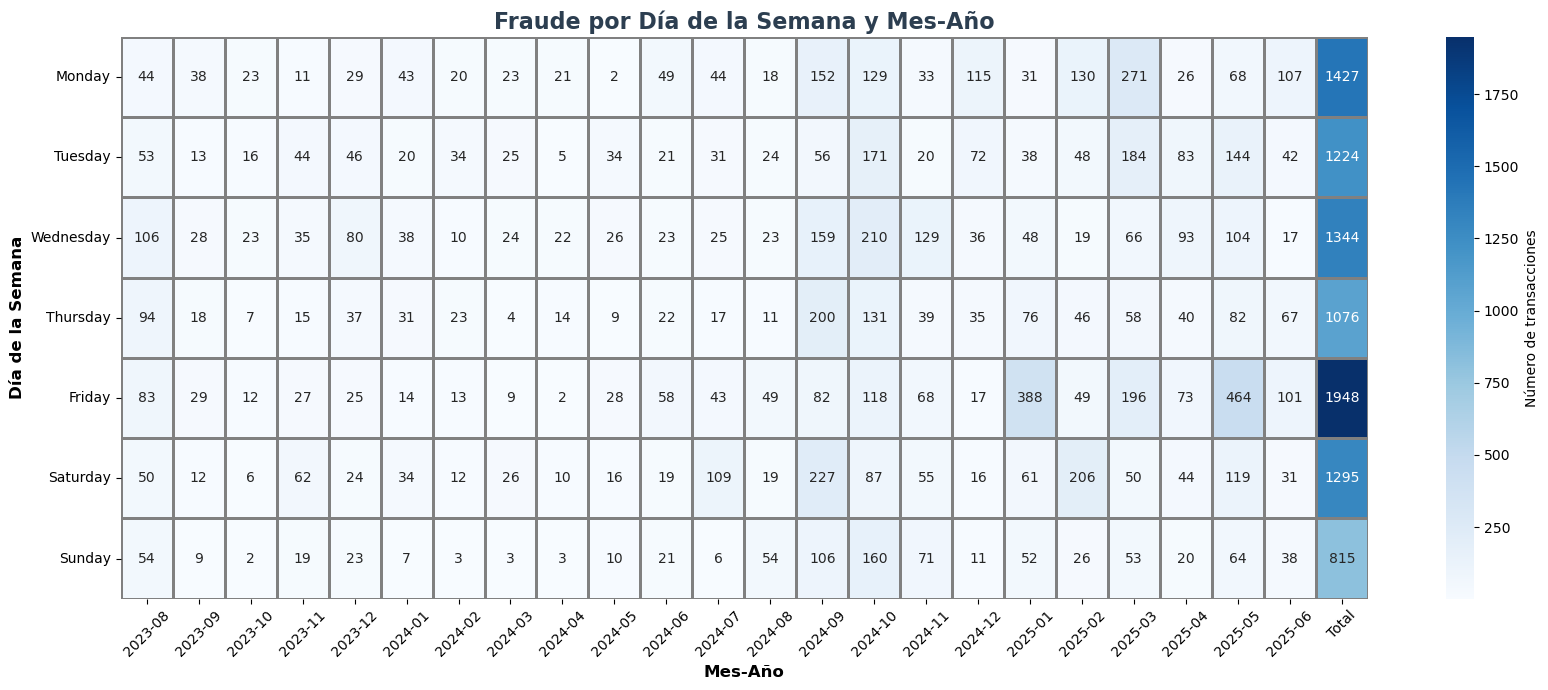

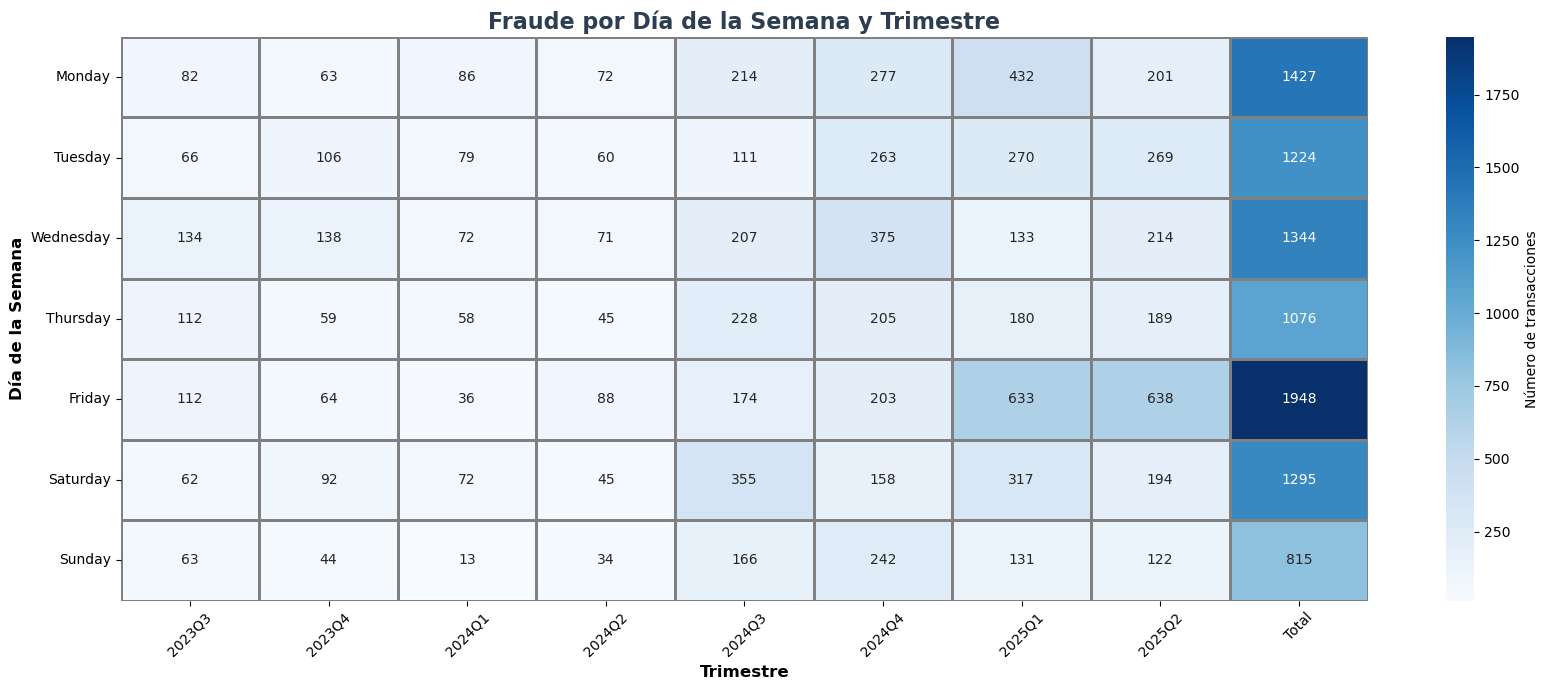

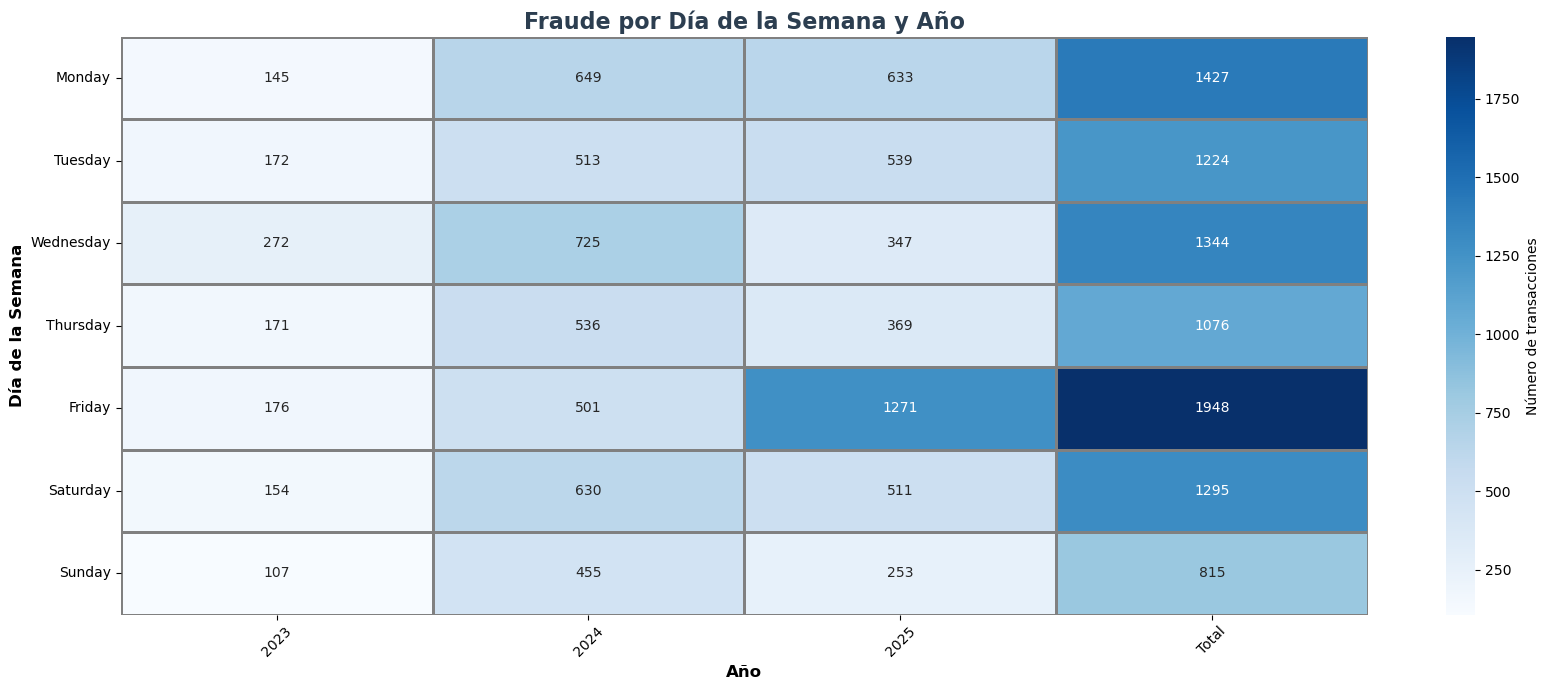

In [133]:

def plot_fraud_heatmap(df, row_field, col_field, value_field, agg_func, title, xlabel, ylabel, cmap='Blues', figsize=(17,7)):
    tabla = df.groupby([row_field, col_field])[value_field].agg(agg_func).unstack().fillna(0).astype(int)
    
    # Ordena los días de la semana si es necesario
    if row_field.lower().startswith('dia'):
        dias_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        tabla = tabla.reindex(dias_order)
    
    totals = tabla.sum(axis=1)
    tabla['Total'] = totals
    
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        tabla, annot=True, fmt='d', cmap=cmap, linewidths=0.8, linecolor='gray',
        cbar_kws={'label': 'Número de transacciones'}
    )
    plt.title(title, fontsize=16, fontweight='bold', color='#2c3e50')
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Mensual
plot_fraud_heatmap(df_filtrado, 'dia_semana', 'mes_year', 'Fraude', 'count',
                   'Fraude por Día de la Semana y Mes-Año', 'Mes-Año', 'Día de la Semana')

# Trimestral
plot_fraud_heatmap(df_filtrado, 'dia_semana', 'trimestre', 'Fraude', 'count',
                   'Fraude por Día de la Semana y Trimestre', 'Trimestre', 'Día de la Semana')

# Anual
plot_fraud_heatmap(df_filtrado, 'dia_semana', 'year', 'Fraude', 'count',
                   'Fraude por Día de la Semana y Año', 'Año', 'Día de la Semana')


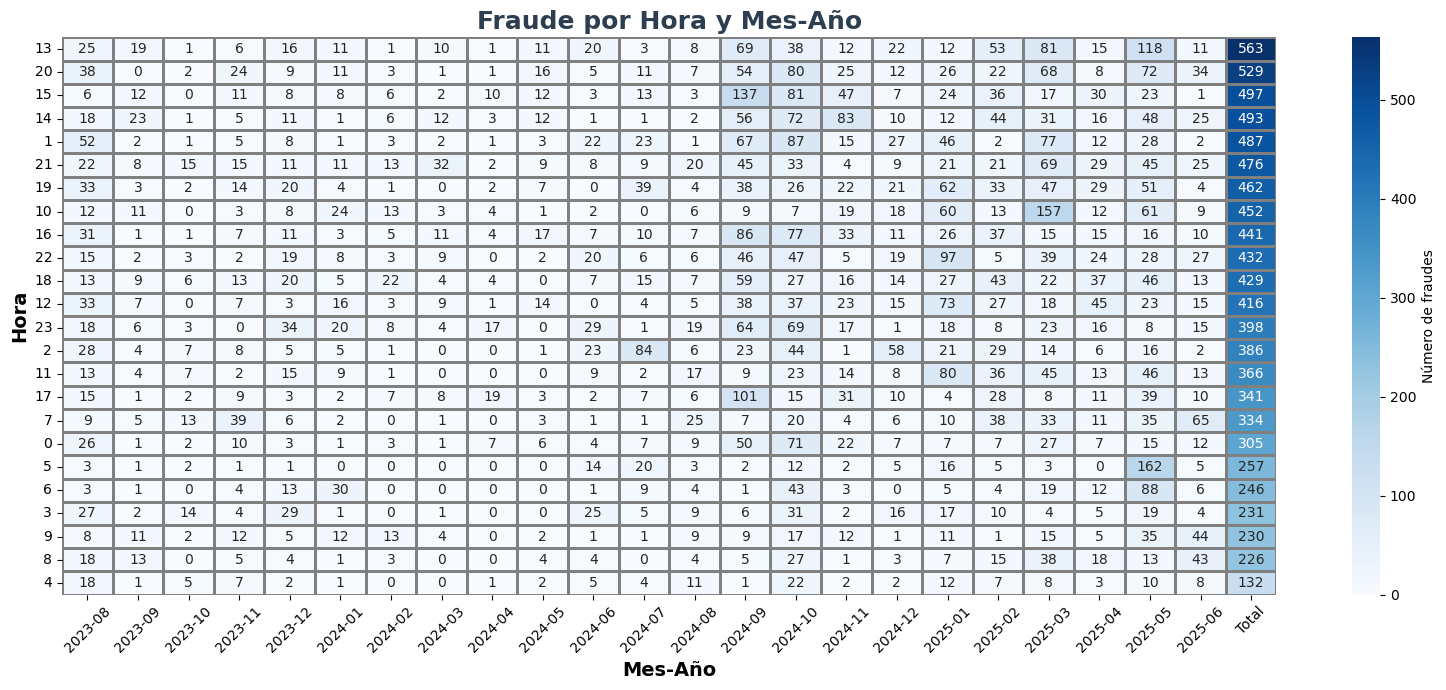

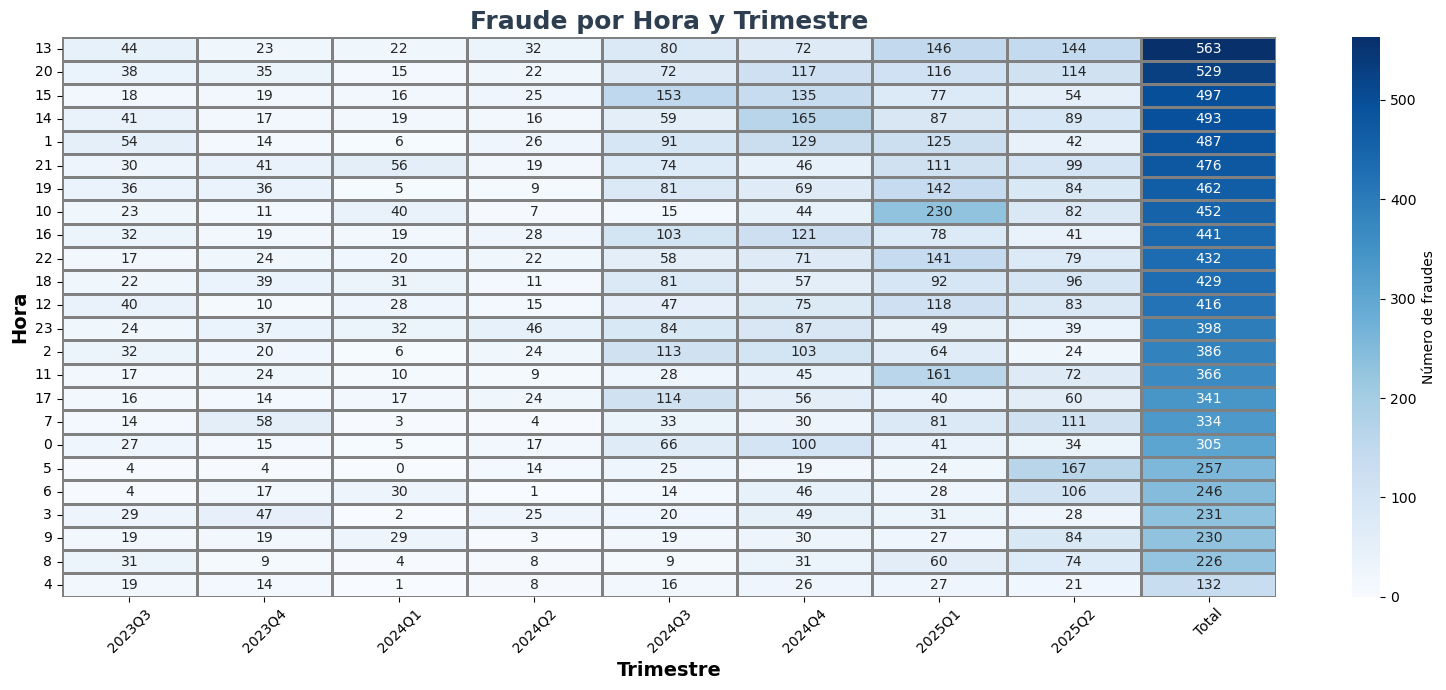

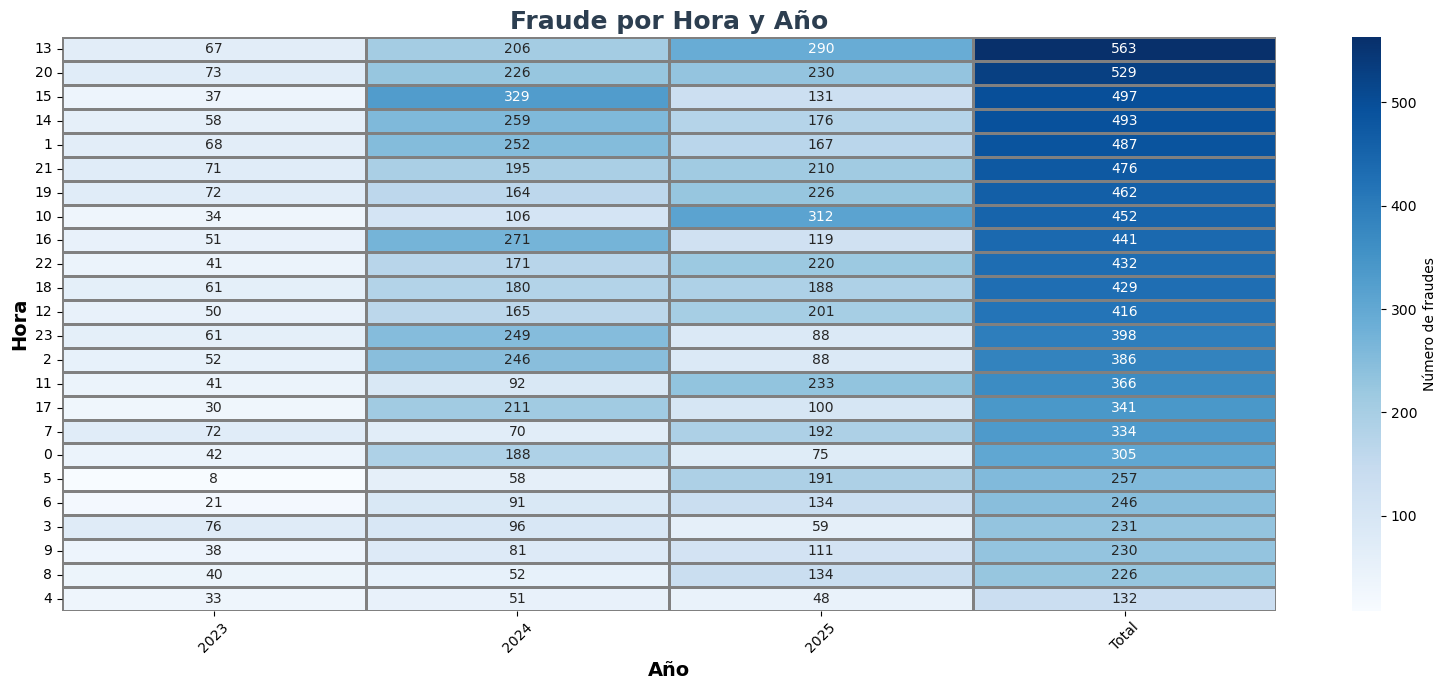

In [134]:

def plot_hourly_heatmap(df, col_field, value_field='DE6_Monto_Dolar', agg_func='count', cmap='Blues', figsize=(16,7), titulo='', xlabel='', ylabel='Hora'):
    # Agrupar y contar fraudes
    tabla = df.groupby(['hora', col_field])[value_field].agg(agg_func).unstack().fillna(0).astype(int)
    # Agregar columna total (puedes quitarlo si no quieres mostrarlo)
    tabla['Total'] = tabla.sum(axis=1)
    # Ordenar por total descendente
    tabla = tabla.sort_values(by='Total', ascending=False)
    
    # Gráfico
    plt.figure(figsize=figsize)
    sns.heatmap(
        tabla,
        annot=True,
        fmt='d',              
        cmap=cmap,
        linewidths=0.8,
        linecolor='gray',
        cbar_kws={'label': 'Número de fraudes'}
    )
    plt.title(titulo, fontsize=18, fontweight='bold', color='#2c3e50')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ---- USO EJEMPLO ----

# Por mes-año
plot_hourly_heatmap(
    df_filtrado, 
    col_field='mes_year', 
    titulo='Fraude por Hora y Mes-Año',
    xlabel='Mes-Año'
)

# Por trimestre
plot_hourly_heatmap(
    df_filtrado, 
    col_field='trimestre', 
    titulo='Fraude por Hora y Trimestre',
    xlabel='Trimestre'
)

# Por año
plot_hourly_heatmap(
    df_filtrado, 
    col_field='year', 
    titulo='Fraude por Hora y Año',
    xlabel='Año'
)



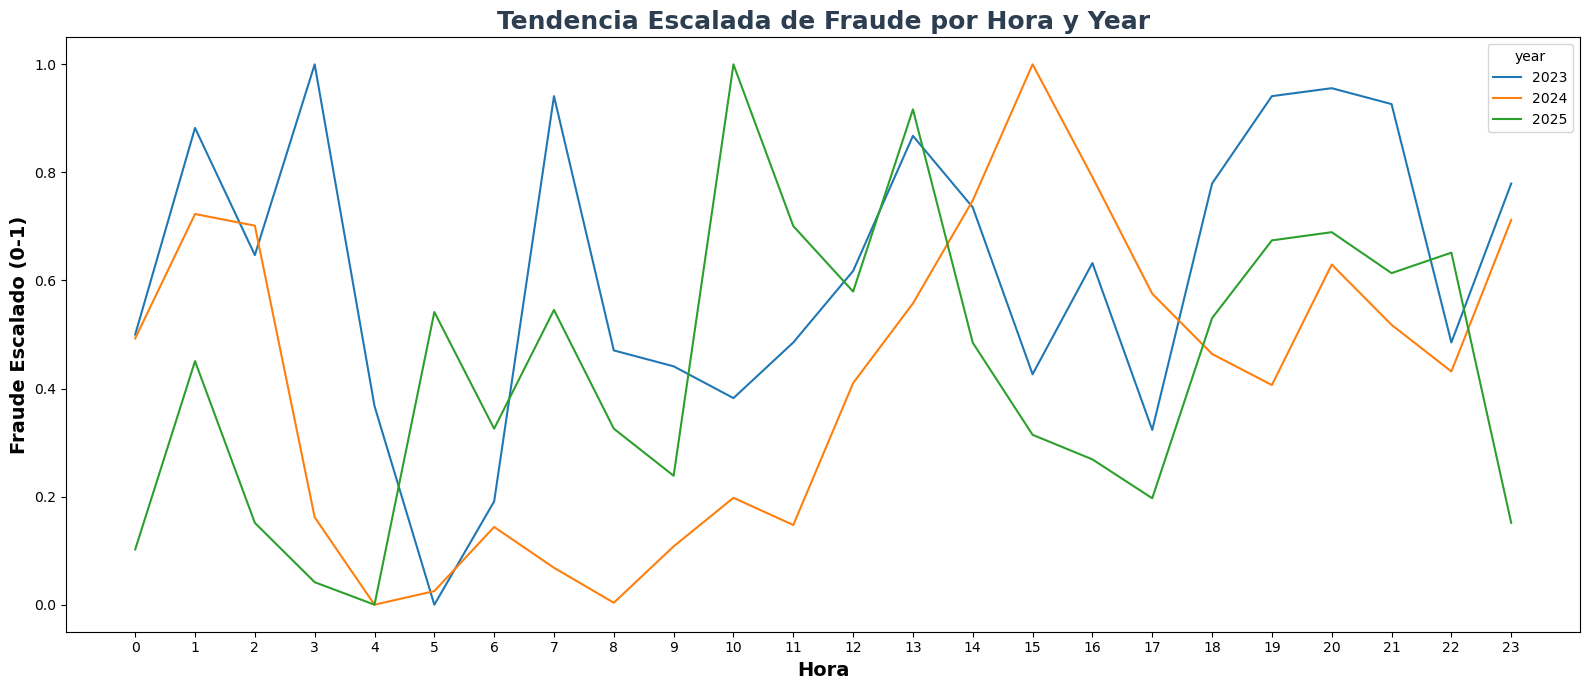

In [135]:



def plot_line_trend_scaled(df, group_field, value_field='Fraude', agg_func='count', periodo='trimestre'):
    # Calcula la cantidad por hora y periodo
    tabla = df.groupby(['hora', periodo])[value_field].agg(agg_func).reset_index()
    # Realiza pivot para tener columnas por periodo
    data_pivot = tabla.pivot(index='hora', columns=periodo, values=value_field).fillna(0)
    # Normaliza cada periodo
    data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data_pivot), columns=data_pivot.columns, index=data_pivot.index)
    data_norm.reset_index(inplace=True)
    data_melt = data_norm.melt(id_vars='hora', var_name=periodo, value_name='NormFraude')
    
    plt.figure(figsize=(16,7))
    sns.lineplot(x='hora', y='NormFraude', hue=periodo, data=data_melt, palette='tab10')
    plt.title(f'Tendencia Escalada de Fraude por Hora y {periodo.capitalize()}', fontsize=18, fontweight='bold', color='#2c3e50')
    plt.ylabel('Fraude Escalado (0-1)', fontsize=14, fontweight='bold')
    plt.xlabel('Hora', fontsize=14, fontweight='bold')
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()

# Uso ejemplo (asegúrate de importar pandas y sklearn)
plot_line_trend_scaled(df_filtrado, 'hora', 'Fraude', 'count', periodo='year')


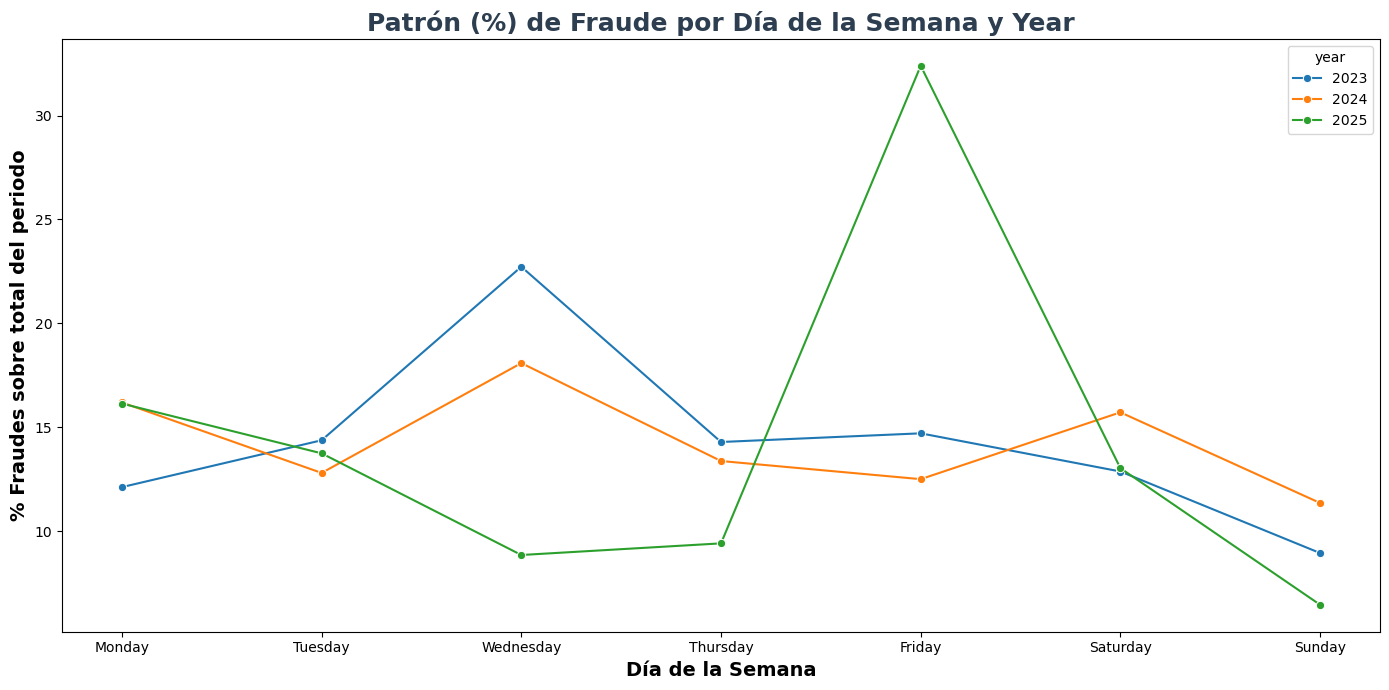

In [136]:
def plot_weekday_trend_normalizado(df, dia_field='dia_semana', periodo='year', value_field='Fraude', agg_func='count'):
    # Calcular fraudes por día de semana y periodo (ej: año)
    tabla = df.groupby([dia_field, periodo])[value_field].agg(agg_func).reset_index()
    # Calcular total anual
    totales = tabla.groupby(periodo)[value_field].transform('sum')
    # % relativo de fraudes de cada día respecto al total del periodo
    tabla['pct_fraudes'] = (tabla[value_field] / totales) * 100

    # Ordenar días de la semana si está en inglés
    dias_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    tabla[dia_field] = pd.Categorical(tabla[dia_field], categories=dias_order, ordered=True)
    tabla = tabla.sort_values([periodo, dia_field])

    plt.figure(figsize=(14,7))
    sns.lineplot(x=dia_field, y='pct_fraudes', hue=periodo, data=tabla, marker='o', palette='tab10')
    plt.title('Patrón (%) de Fraude por Día de la Semana y ' + periodo.capitalize(), fontsize=18, fontweight='bold', color='#2c3e50')
    plt.ylabel('% Fraudes sobre total del periodo', fontsize=14, fontweight='bold')
    plt.xlabel('Día de la Semana', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Uso ejemplo:
plot_weekday_trend_normalizado(df_filtrado, dia_field='dia_semana', periodo='year', value_field='Fraude')

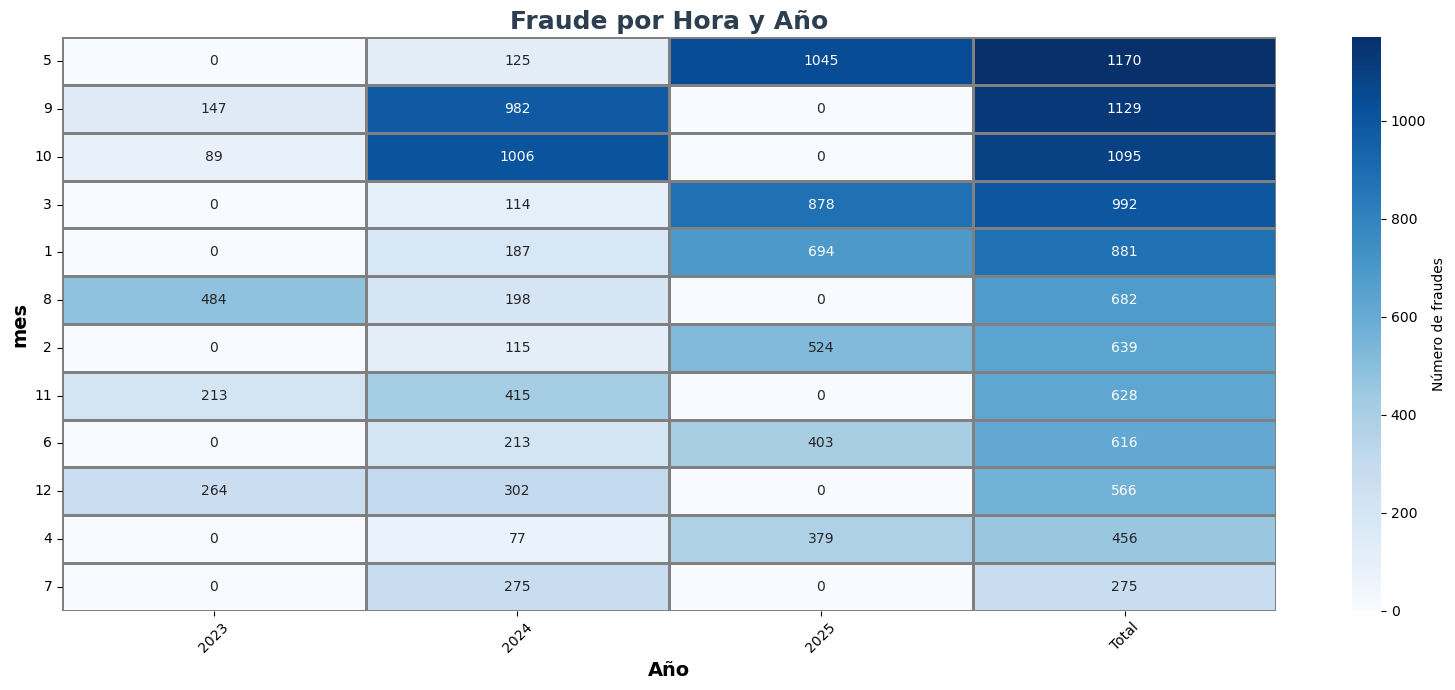

In [137]:


def plot_hourly_heatmap(df, col_field, value_field='DE6_Monto_Dolar', agg_func='count', cmap='Blues', figsize=(16,7), titulo='', xlabel='', ylabel='mes'):
    # Agrupar y contar fraudes
    tabla = df.groupby(['mes', col_field])[value_field].agg(agg_func).unstack().fillna(0).astype(int)
    # Agregar columna total (puedes quitarlo si no quieres mostrarlo)
    tabla['Total'] = tabla.sum(axis=1)
    # Ordenar por total descendente
    tabla = tabla.sort_values(by='Total', ascending=False)
    
    # Gráfico
    plt.figure(figsize=figsize)
    sns.heatmap(
        tabla,
        annot=True,
        fmt='d',              
        cmap=cmap,
        linewidths=0.8,
        linecolor='gray',
        cbar_kws={'label': 'Número de fraudes'}
    )
    plt.title(titulo, fontsize=18, fontweight='bold', color='#2c3e50')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Por año
plot_hourly_heatmap(
    df_filtrado, 
    col_field='year', 
    titulo='Fraude por Hora y Año',
    xlabel='Año'
)

